## Семинар 11
# Тема:  Работа с выбросами

Выбросы – это точки данных в признаке, которые отклоняются от нормы значений этого признака.

Нет однозначного способа понять, что перед нами выброс. Разные способы обнаружения выбросов возвращают разные точки в качестве выбросов, и эти точки пересекаются лишь частично.


**Способы обнаружения выбросов:**

1. Поиск по порогу. 

Этот способ представляет собой погружение в предметную область и понимание того, какие значения признаки могут принимать, а какие - не могут.

2. Обнаружение и обработка выбросов, используя метод **IQR** (interquartile range, межквартильное расстояние).

Строим `boxplot` и все значения вне "усов" считаем выбросами. Левая линия ящика обозначает первый квартиль (25-й перцентиль q25), а правая линия ящика обозначает третий квартиль (75-й перцентиль q75). Границы "усов" определяются так: 

нижняя граница - это минимальное значение признака между q25 - (1.5*iqr) и q75 + (1.5*iqr),

верхняя граница  - это максимальное значение признака между q25 - (1.5*iqr) и q75 + (1.5*iqr), 

где  iqr = q75-q25

Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами "усов".
   
3.  Поиск по отклонению (z-score)
  
Поиск по отклонению основан на поиске значения, на которое отклоняется данная точка от среднего. Делается это с помощью z-score, то есть, расстояния (измеряемого в количестве стандартных отклонений) от среднего значения точек.  

4. Поиск выбросов с помощью методов машинного обучения

Например, изолирующий лес (Isolation Forest) 

**Способы борьбы с выбросами:**

- Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем).
- Заменять выбросы разными методами (использовать знания по предметной области, медианы, средние значения, np.clip и т.д.) 
- Делать/не делать дополнительную фичу. 
- Ничего не делать

Импортируем необходимые библиотеки:

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.ensemble import IsolationForest

### 1. Загрузите датасет apartament.csv и выведите первые 5 строк. 

In [21]:
data = pd.read_csv('apartment.csv')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


### 2. Создайте копию загруженного датафрейма и выведите информацию о данных.

In [22]:
copy_df = data.copy()
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### 3. Осуществите обнаружение выбросов **по порогу** для признака `Rooms`. Для этого используйте следующие знания по предметной области: количество комнат не может быть 0 и больше 6. Выведите индексы тех наблюдений, где количество комнат не удовлетворяет этим условиям. Подсчитайте их количество.

In [23]:

copy_df['Rooms'].value_counts()

Rooms
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: count, dtype: int64

In [24]:
rooms_index = copy_df.loc[(copy_df['Rooms']) < 1 | (copy_df['Rooms'] > 6), 'Rooms'].index
rooms_index

Index([2194, 3780, 5894, 6401, 7644, 7929, 9767, 9869], dtype='int64')

In [25]:
rooms_index.value_counts().sum()

np.int64(8)

In [26]:
copy_df.iloc[rooms_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


### 4. Обработайте выбросы в пизнаке Rooms, например, так: если число комнат равно нулю, то замените его на 1, если больше 6 - на 6. Добавьте к исходному датасету признак Rooms_outlier, в котором на местах с выбросами стоят 1, а остальные - 0. 

In [27]:
copy_df['Rooms_outlier'] = 0
copy_df.loc[(copy_df['Rooms'] == 0) | (copy_df['Rooms'] > 6), 'Rooms_outlier' ] = 1


In [ ]:
copy_df['Rooms_outlier'].value_counts()

Rooms_outlier
0    9989
1      11
Name: count, dtype: int64

In [28]:
copy_df.loc[copy_df['Rooms'] == 0, 'Rooms' ] = 1
copy_df.loc[copy_df['Rooms'] > 6, 'Rooms' ] = 6

In [29]:
copy_df['Rooms'].value_counts()

Rooms
2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       4
Name: count, dtype: int64

In [34]:
copy_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


### 5. Для признака Ecology_1 осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально определите наличие выбросов. 

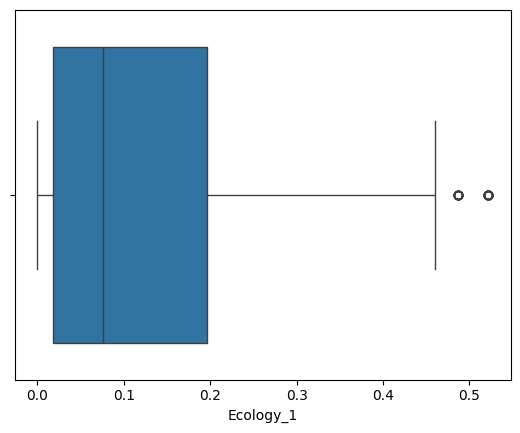

In [52]:
plt.figure()
sns.boxplot(x= copy_df['Ecology_1'])
plt.show()

### 6. Используя функцию outliers_iqr определите индексы наблюдений с выбросами. Подсчитайте их количество.

In [30]:
def outliers_iqr(x):
    q25 = x.quantile(.25)
    q75 = x.quantile(.75)  
    iqr = q75 - q25   
    lower_bound = q25 - iqr * 1.5  
    upper_bound = q75 + iqr * 1.5 
    outliers_index = x[(x > upper_bound) | (x < lower_bound)].index
    min_border = x[(x <= upper_bound) & (x >= lower_bound)].min()
    max_border = x[(x <= upper_bound) & (x >= lower_bound)].max()
    return outliers_index, min_border, max_border

In [ ]:
outliers_index, min_border, max_border = outliers_iqr(x=copy_df['Ecology_1'])
min_border, max_border

(np.float64(0.0), np.float64(0.460556389))

In [50]:
outliers_index

Index([ 201,  516,  704,  719,  798,  802, 1041, 1051, 1351, 1386, 1772, 2073,
       2080, 2135, 2226, 2446, 2495, 2536, 3049, 3305, 3511, 4063, 4089, 4265,
       4373, 4519, 4561, 4719, 4985, 5082, 5200, 5244, 5311, 5401, 5420, 5439,
       5777, 5807, 5903, 6140, 6199, 6231, 6426, 7375, 7450, 7609, 7836, 8223,
       8240, 8308, 8362, 8435, 8587, 8629, 9188, 9347, 9368, 9371, 9627, 9958,
       9985],
      dtype='int64')

In [51]:
outliers_index.value_counts().sum()

np.int64(61)

### 7. Обработайте выбросы в пизнаке Ecology_1, например, так: замените их на np.nan и далее удалите наблюдения с пропусками в пизнаке Ecology_1.

In [54]:
copy_df.loc[outliers_index, 'Ecology_1' ] = np.nan
copy_df = copy_df.dropna(subset='Ecology_1', axis=0,ignore_index=True)
copy_df.shape

(9939, 21)

### 8. Снова постройте "ящик с усами" для этого признака и убедитесь, что выбросов больше нет.

In [ ]:
plt.figure()
sns.boxplot(x= copy_df['Ecology_1'])
plt.show()

### 9. Для признака Square осуществите обнаружение выбросов методом **z-score**. Для этого используйте функцию outliers_z_score и определите индексы наблюдений с выбросами. Подсчитайте их количество.

In [31]:
def outliers_z_score(x, threshold=3):
    mean = np.mean(x)
    std = np.std(x)
    z_scores = [(element - mean) / std for element in x]
    print(len(z_scores))
    return np.where(np.abs(z_scores) > threshold)[0]

In [57]:
outliers_z_index = outliers_z_score(copy_df['Square'])
outliers_z_index

9939


array([ 136,  285,  348,  402,  442,  510,  597,  690,  722,  726,  860,
       1078, 1164, 1343, 1439, 1449, 1596, 1604, 1682, 1719, 1765, 1840,
       1895, 1938, 1969, 2026, 2030, 2055, 2073, 2252, 2310, 2321, 2378,
       2388, 2414, 2499, 2645, 2772, 2945, 2992, 3102, 3163, 3185, 3934,
       4419, 4586, 4649, 4967, 5002, 5226, 5227, 5251, 5375, 5440, 5550,
       5595, 5728, 5806, 5953, 5991, 6060, 6168, 6301, 6407, 6457, 6506,
       6575, 6786, 6866, 6963, 6967, 7101, 7130, 7353, 7598, 7664, 7832,
       7964, 7997, 8008, 8081, 8414, 8623, 8818, 8983, 9050, 9174, 9252,
       9475, 9604, 9708, 9787, 9818])

In [61]:
len(outliers_z_index)

93

### 10.  Обработайте выбросы в пизнаке Square заменив их медианным значением. Добавьте к исходному датасету признак Square_outlier, в котором на местах с выбросами стоят 1, а остальные - 0. 

In [63]:
copy_df['Square_outlier'] = 0
copy_df.loc[outliers_z_index, 'Square_outlier' ] = 1
copy_df.loc[outliers_z_index, 'Square' ] = copy_df['Square'].median()


In [65]:
copy_df['Square_outlier'].value_counts()

Square_outlier
0    9846
1      93
Name: count, dtype: int64

In [64]:
copy_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,0,0


# Задания для самостоятельного выполнения
Продолжите работу с рассматриваемым датасетом `apartment.csv`. 
1. Осуществите обнаружение выбросов **по порогу** для признака `KitchenSquare`. Для этого используйте следующие знания по предметной области: площадь кухни не может быть меньше 3 и больше 13 метров. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.
2. Обработайте выбросы в пизнаке `KitchenSquare`, например, так: площадь кухни меньше 3, то замените его на 3, если больше 13 - на медианное значение. Добавьте к исходному датасету признак `KitchenSquare_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0. 
3. Осуществите обнаружение выбросов **по порогу** для признака `Floor`. Для этого используйте следующие знания по предметной области: этаж квартиры `Floor` не должен быть больше этажности дома `HouseFloor`. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.
4. Обработайте выбросы в пизнаке `Floor`, например, так: замените этаж квартиры `Floor` на случайный от 0 (подвал) до числа этажей в доме `HouseFloor`. Добавьте к исходному датасету признак `Floor_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0. 
5. Для признака `Social_1` осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально убедитесь, что выбросов нет. 
6. Для признака `Social_2` осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально определите наличие выбросов. Используя функцию `outliers_iqr` определите индексы наблюдений с выбросами. Подсчитайте их количество.
7. Обработайте выбросы в пизнаке `Social_2`, например, так: замените их на np.nan и далее удалите наблюдения с пропусками.
8. Для признака `Social_3` осуществите обнаружение выбросов методом **z-score**. Для этого используйте функцию `outliers_z_score` и определите индексы наблюдений с выбросами. Подсчитайте их количество.
9.  Обработайте выбросы в пизнаке `Social_3` заменив их медианным значением. Добавьте к исходному датасету признак `Social_3_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0.
10. Осуществите обнаружение выбросов для признака `HouseYear` используя модель IsolationForest(contamination = 0.1, random_state = 42).